# Quantifying SAM's performance on segmentation of crops in satellite imagery: Results

 * File Created: Friday, 22nd September 2023 11:20:45 pm
 * Author: Rutuja Gurav (rgura001@ucr.edu)
 
Prerequisites to running this notebook - 
1. Made all samples needed using `make_aoi_samples.py`.
2. Ran `grid_search.py`.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.2.1
True
8


In [3]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [4]:
%matplotlib inline
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor']='white'
import seaborn as sns
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white',
        })

from scipy import ndimage
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import sys, glob, os, collections
from pprint import pprint

matplotlib version: 3.7.5


# Visualize grid search results

In [5]:
RESULTS_DIR = "../results"

##### Sample Size = 300

In [6]:
num_samples = 300
aoi_sizes = [1098, 549, 274, 137]
results = []
for aoi_size in aoi_sizes:
    results.append(pd.read_csv(RESULTS_DIR+"/grid_search/num_samples_{}/aoi_size_{}/results.csv".format(num_samples, aoi_size)))
results = pd.concat(results)
results['#pred_labels-#gt_labels'] = results['num_labels_in_pred_mask'] - results['num_labels_in_gt_mask']
print(collections.Counter(results['pps_perc']))
results

Counter({1.0: 6000, 2.5: 6000, 5.0: 6000, 7.5: 6000, 10.0: 6000})


sample_idx   aoi  pps  pps_perc  mmra  mmra_perc  crop_n_layers  \
0            322  1098   11       1.0  1206        0.1              1   
1            114  1098   11       1.0  1206        0.1              1   
2            325  1098   11       1.0  1206        0.1              1   
3            267  1098   11       1.0  1206        0.1              1   
4            307  1098   11       1.0  1206        0.1              1   
...          ...   ...  ...       ...   ...        ...            ...   
7495       10706   137   14      10.0  1877       10.0              1   
7496       30731   137   14      10.0  1877       10.0              1   
7497       41276   137   14      10.0  1877       10.0              1   
7498       16426   137   14      10.0  1877       10.0              1   
7499       64511   137   14      10.0  1877       10.0              1   

      crop_n_points_downscale_factor  nms_thresh    FMI    ARI     MI    AMI  \
0                                  1         0.7  0.138  0.061  1.640  0.461   
1                                  1         0.7  0.217  0.068  0.873  0.322   
2                                  1         0.7  0.193  0.047  1.099  0.360   
3                                  1         0.7  0.300  0.051  0.517  0.269   
4                                  1         0.7  0.181  0.010  0.695  0.242   
...                              ...         ...    ...    ...    ...    ...   
7495                               1         0.7  0.420  0.037  0.160  0.138   
7496                               1         0.7  0.558  0.406  0.795  0.483   
7497                               1         0.7  0.426  0.116  0.225  0.163   
7498                               1         0.7  0.501  0.274  0.619  0.428   
7499                               1         0.7  0.386  0.207  0.601  0.349   

        NMI  Homogeneity  Completeness  V-Measure  num_labels_in_pred_mask  \
0     0.461        0.744         0.334      0.461                    230.0   
1     0.322        0.511         0.235      0.322                    136.0   
2     0.361        0.561         0.266      0.361                    243.0   
3     0.269        0.361         0.214      0.269                     79.0   
4     0.243        0.389         0.177      0.243                    250.0   
...     ...          ...           ...        ...                      ...   
7495  0.139        0.316         0.089      0.139                     13.0   
7496  0.484        0.601         0.405      0.484                     15.0   
7497  0.164        0.298         0.114      0.164                     16.0   
7498  0.428        0.596         0.334      0.428                     10.0   
7499  0.349        0.429         0.294      0.349                     11.0   

      num_labels_in_gt_mask  #pred_labels-#gt_labels  
0                      18.0                    212.0  
1                      19.0                    117.0  
2                      21.0                    222.0  
3                      22.0                     57.0  
4                      23.0                    227.0  
...                     ...                      ...  
7495                    4.0                      9.0  
7496                    7.0                      8.0  
7497                    9.0                      7.0  
7498                    7.0                      3.0  
7499                    7.0                      4.0  

[30000 rows x 20 columns]

In [7]:
results = results.sort_values(by=['FMI'], ascending=False)
results

sample_idx   aoi  pps  pps_perc    mmra  mmra_perc  crop_n_layers  \
6223       41554   137    2       1.0    1877       10.0              1   
5031       41554   137    4       2.5     939        5.0              1   
6531       41554   137    4       2.5    1877       10.0              1   
4723       41554   137    2       1.0     939        5.0              1   
1655       21421   137    2       1.0      94        0.5              1   
...          ...   ...  ...       ...     ...        ...            ...   
2826           6  1098  110      10.0    6029        0.5              1   
7026           6  1098   83       7.5  120561       10.0              1   
6726           6  1098   55       5.0  120561       10.0              1   
7326           6  1098  110      10.0  120561       10.0              1   
6426           6  1098   28       2.5  120561       10.0              1   

      crop_n_points_downscale_factor  nms_thresh    FMI    ARI     MI    AMI  \
6223                               1         0.7  1.000  1.000  0.000  1.000   
5031                               1         0.7  1.000  1.000  0.000  1.000   
6531                               1         0.7  1.000  1.000  0.000  1.000   
4723                               1         0.7  1.000  1.000  0.000  1.000   
1655                               1         0.7  0.997 -0.002  0.000 -0.000   
...                              ...         ...    ...    ...    ...    ...   
2826                               1         0.7  0.080 -0.005  0.409  0.137   
7026                               1         0.7  0.079 -0.002  0.426  0.141   
6726                               1         0.7  0.079 -0.002  0.415  0.138   
7326                               1         0.7  0.078 -0.003  0.400  0.134   
6426                               1         0.7  0.078 -0.003  0.412  0.137   

        NMI  Homogeneity  Completeness  V-Measure  num_labels_in_pred_mask  \
6223  1.000        1.000         1.000      1.000                      1.0   
5031  1.000        1.000         1.000      1.000                      1.0   
6531  1.000        1.000         1.000      1.000                      1.0   
4723  1.000        1.000         1.000      1.000                      1.0   
1655  0.000        0.000         0.000      0.000                      2.0   
...     ...          ...           ...        ...                      ...   
2826  0.137        0.443         0.081      0.137                    256.0   
7026  0.142        0.461         0.084      0.142                    256.0   
6726  0.138        0.450         0.082      0.138                    255.0   
7326  0.134        0.433         0.079      0.134                    256.0   
6426  0.137        0.446         0.081      0.137                    252.0   

      num_labels_in_gt_mask  #pred_labels-#gt_labels  
6223                    1.0                      0.0  
5031                    1.0                      0.0  
6531                    1.0                      0.0  
4723                    1.0                      0.0  
1655                    2.0                      0.0  
...                     ...                      ...  
2826                    9.0                    247.0  
7026                    9.0                    247.0  
6726                    9.0                    246.0  
7326                    9.0                    247.0  
6426                    9.0                    243.0  

[30000 rows x 20 columns]

Looks like, as expected, the high FMI samples have smaller AOI.

Let's take a look at samples in the tails and figure out what's different between samples in top and bottom tails.

#### Aggregate violin plots

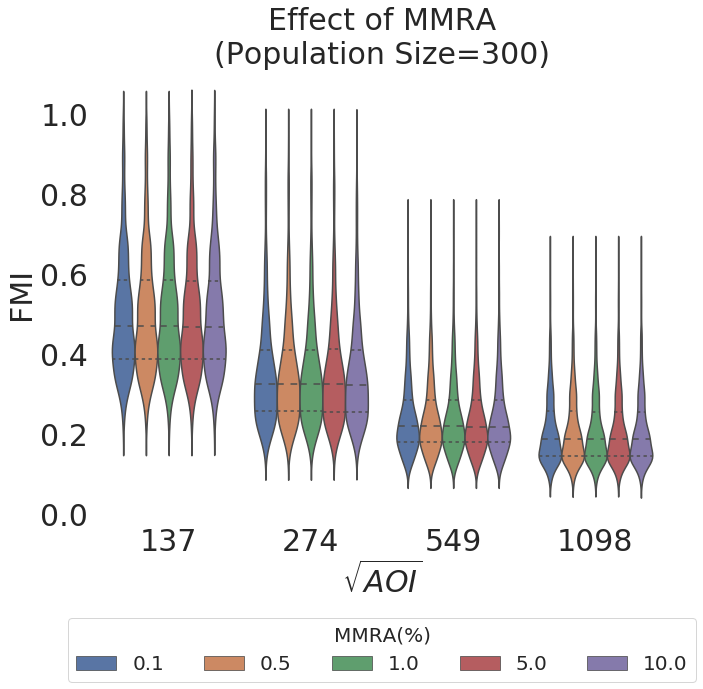

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


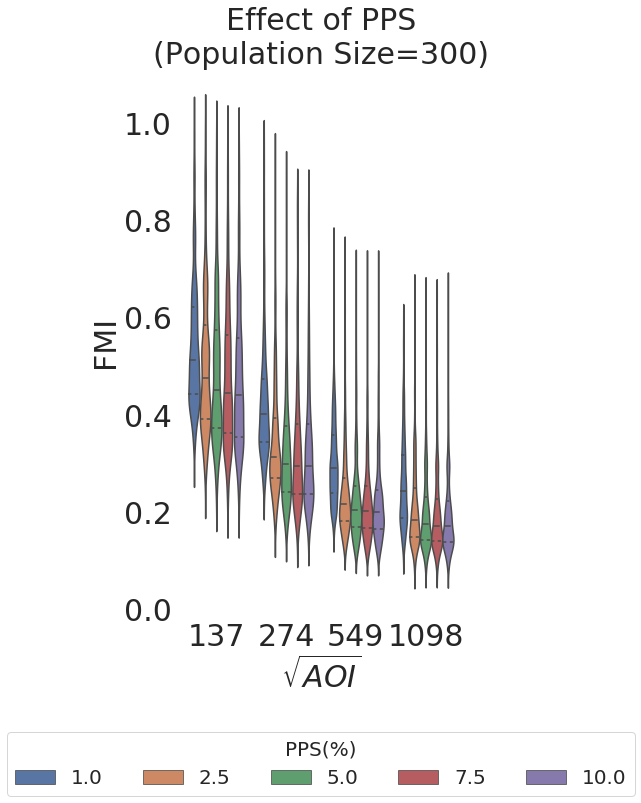

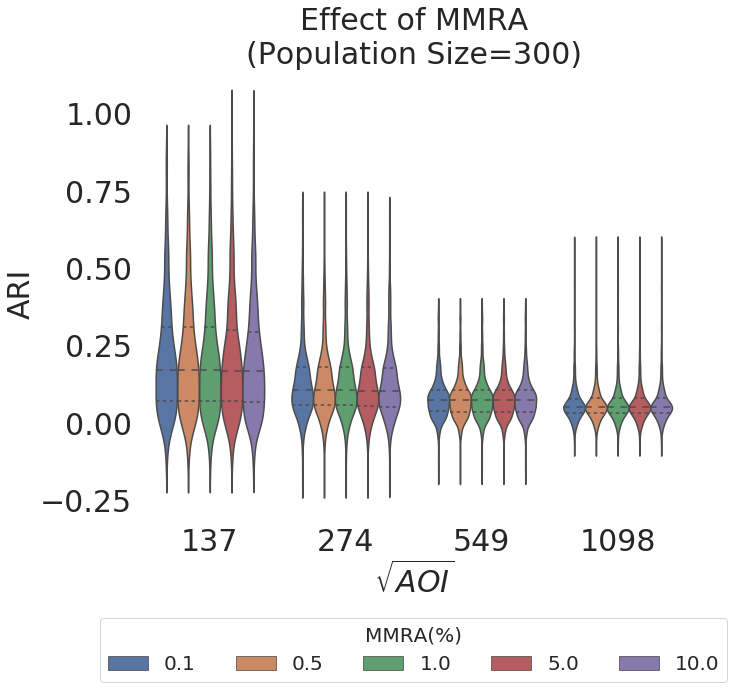

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


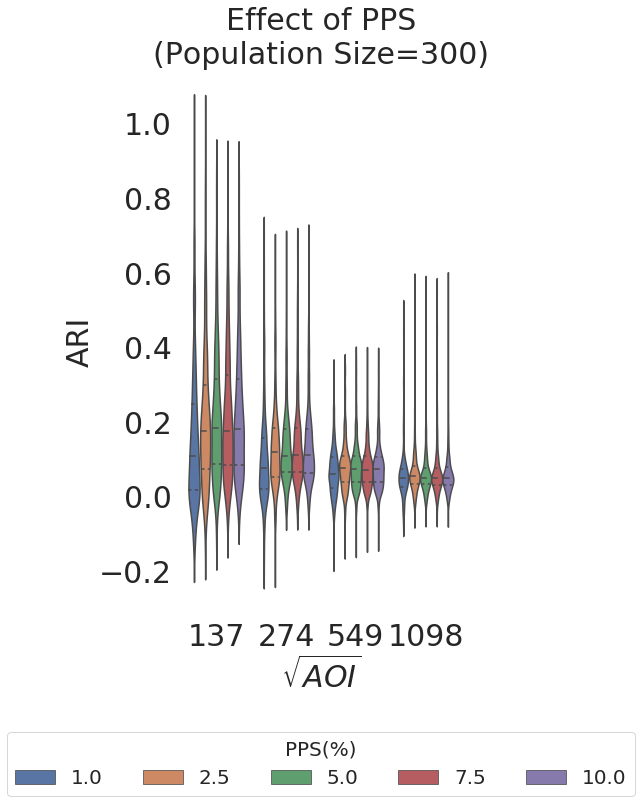

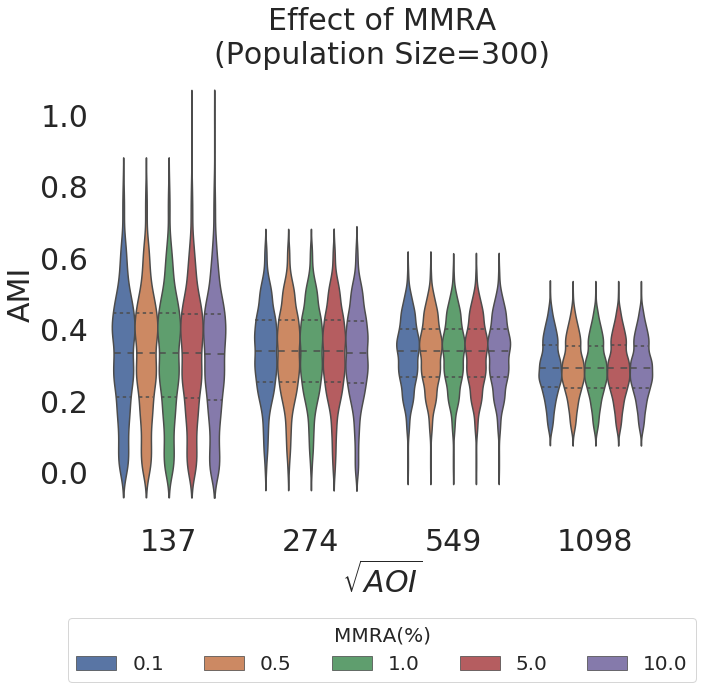

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


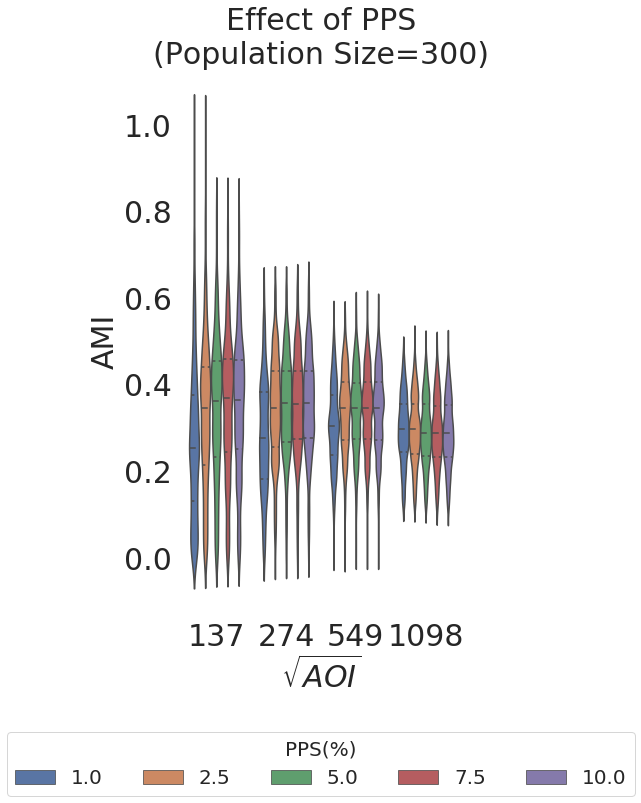

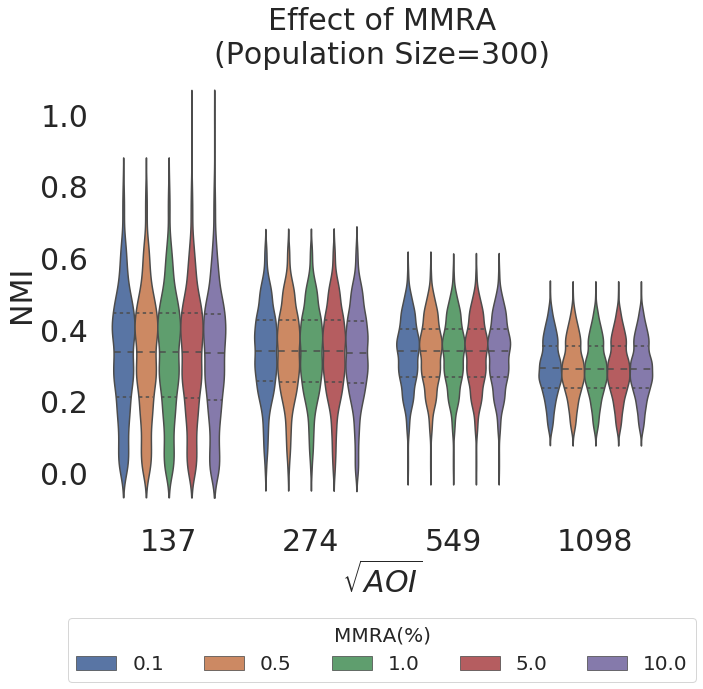

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


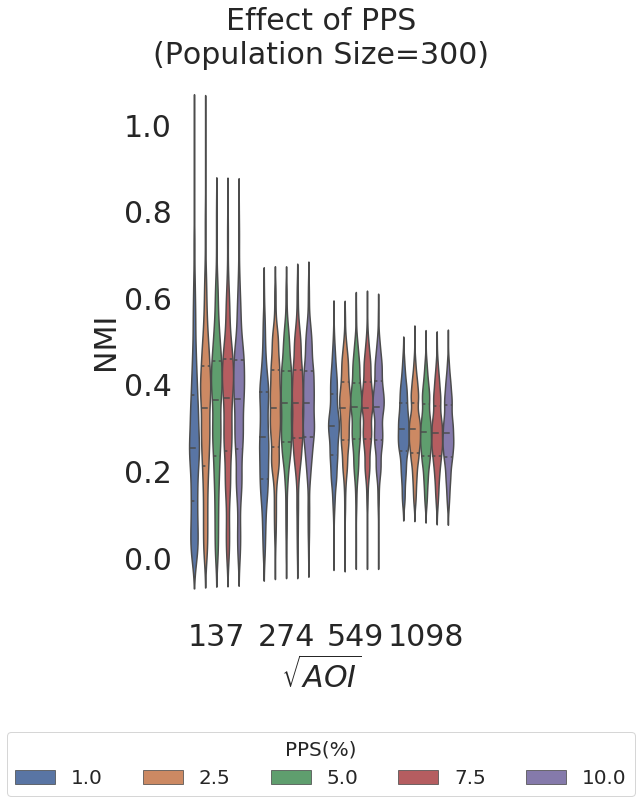

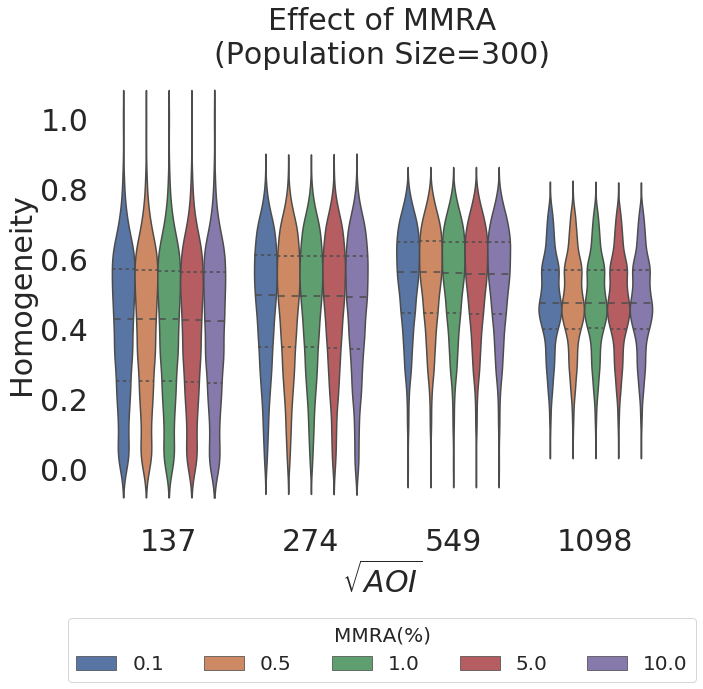

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


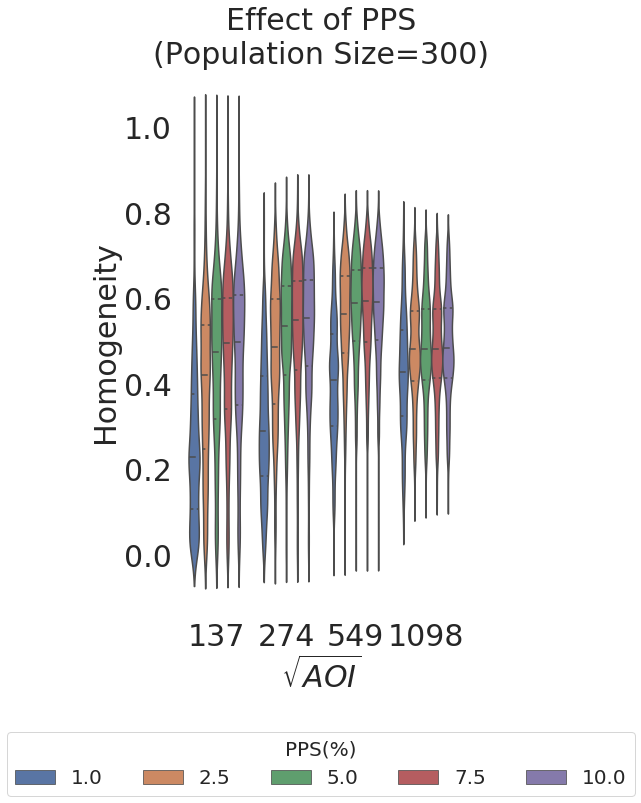

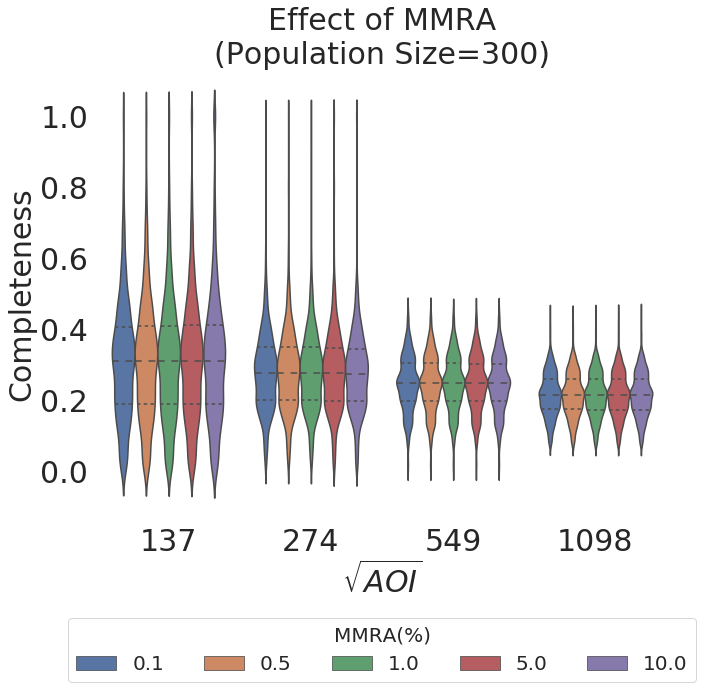

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


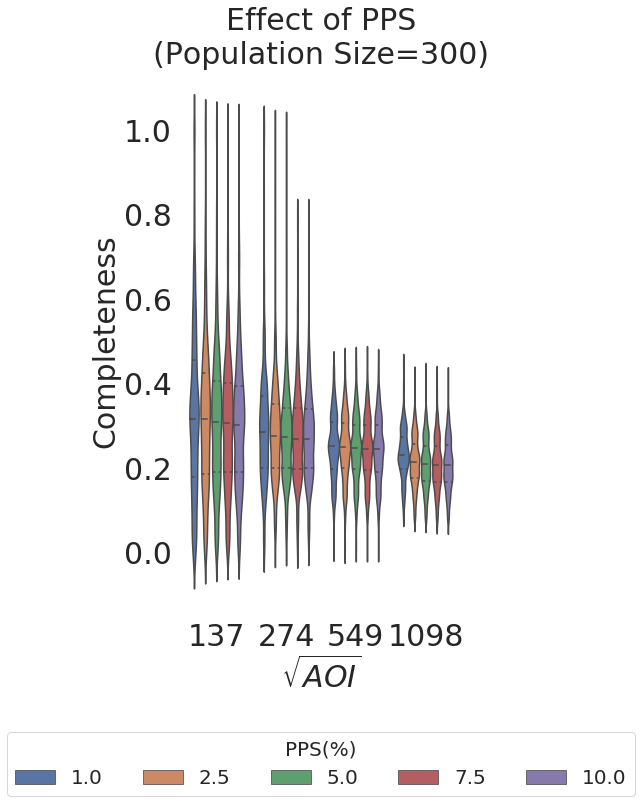

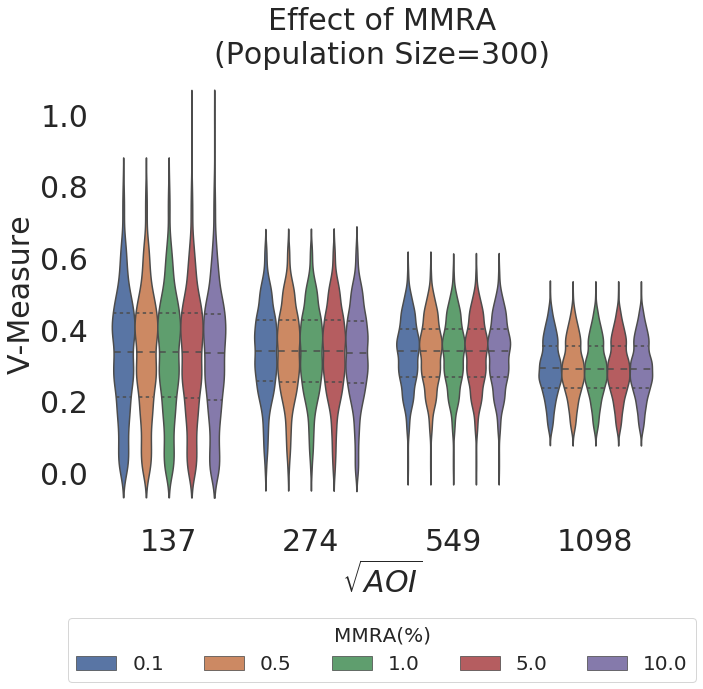

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


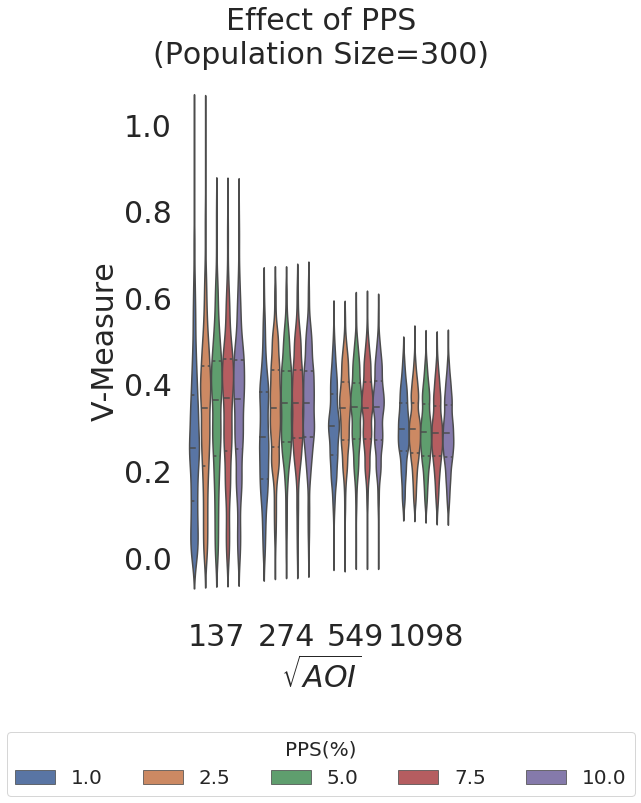

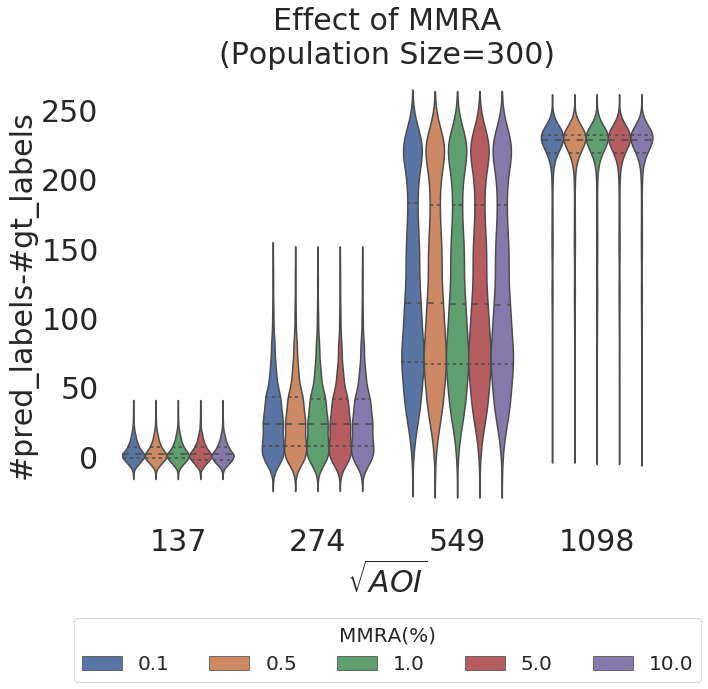

<ipython-input-12-27ed59b26b03>:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


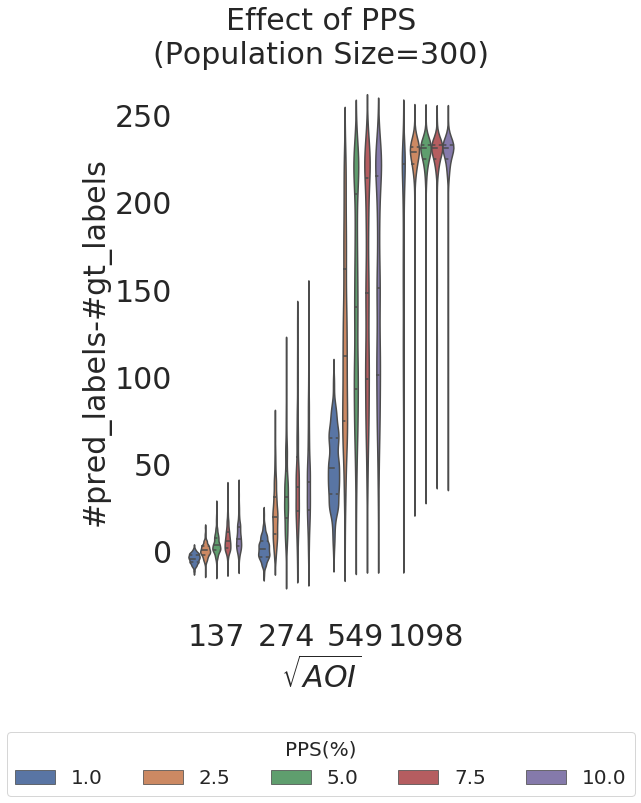

In [12]:
metrics = ['FMI', 
           'ARI', 'AMI', 'NMI', 
           'Homogeneity', 'Completeness', 'V-Measure',
           '#pred_labels-#gt_labels'
        ]
metrics_bounds = [(-0.1,1.1), (-1.1,1.1), (-0.1,1.1), (-0.1,1.1),
                    (-0.1,1.1), (-0.1,1.1), (-0.1,1.1)
                ]
# x = results['aoi'].astype(str)
## results = results[results['aoi']==137]
for metric in metrics:
    ##--------------------------------------------------------------------------------------------------------------
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=30)

    plot = sns.violinplot(data=results, #results[results['pps_perc']==5.0], 
                            x="aoi", y=metric, hue="mmra_perc", 
                            bw = 0.2,  cut=2,
                            inner='quartile', ax=ax)
    # plot = sns.lineplot(data=results, x=x, y=metric, hue="mmra_perc", ax=ax)
    # plot.set_ylabel(plot.get_ylabel(), size=30)
    # plot.set_xlabel(plot.get_xlabel(), size=30)
    ax.set_title(f"Effect of MMRA\n(Population Size={num_samples})", fontsize=30)
    # ax.set_ylim(metrics_bounds[metrics.index(metric)])
    ax.set_ylabel(metric, fontsize=30)
    ax.set_xlabel(r"$\sqrt{AOI}$", fontsize=30)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5,
              fontsize=20, title="MMRA(%)", title_fontsize=20)
    plt.tight_layout()
    # plt.savefig(RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/agg_plots/{metric}_mmraVaoi.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    ##--------------------------------------------------------------------------------------------------------------
    fig, ax = plt.subplots(1,1, figsize=(5,10))
    ax.tick_params(axis='both', which='major', labelsize=30)
    plot = sns.violinplot(data=results, #results[results['mmra_perc']==5.0], 
                            x="aoi", y=metric, hue="pps_perc", 
                            bw = 0.2,  cut=2,
                            inner='quartile', ax=ax)
    # plot = sns.lineplot(data=results, x=x, y=metric, hue="pps_perc", ax=ax)
    # plot.set_ylabel(plot.get_ylabel(), size=30)
    # plot.set_xlabel(plot.get_xlabel(), size=30)
    ax.set_title(f"Effect of PPS\n(Population Size={num_samples})", fontsize=30)
    # ax.set_ylim(metrics_bounds[metrics.index(metric)])
    ax.set_ylabel(metric, fontsize=30)
    ax.set_xlabel(r"$\sqrt{AOI}$", fontsize=30)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=5,
              fontsize=20, title="PPS(%)", title_fontsize=20)

    plt.tight_layout()
    # plt.savefig(RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/agg_plots/{metric}_ppsVaoi.png", dpi=300, bbox_inches="tight")
    plt.show()

#### Aggregate violin plots by AOI

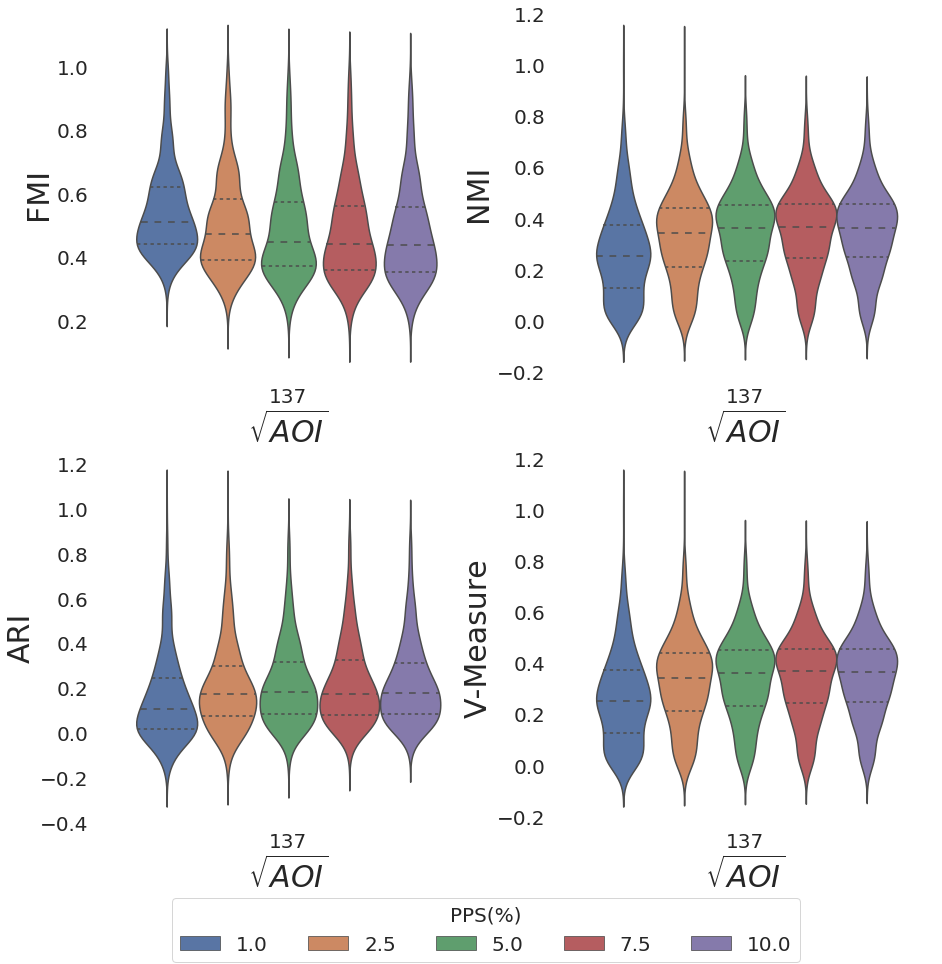

In [13]:
metrics = ['FMI', 'NMI', 'ARI', 'V-Measure']
metrics_bounds = [(-0.1,1.1), (-0.1,1.1), 
                  (-1.1,1.1), (-0.1,1.1)]
aoi_size = aoi_sizes[3]
aoi_results = results[results['aoi']==aoi_size]
fig, axes = plt.subplots(2,2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        metric = metrics[i*2+j]
        axes[i,j].tick_params(axis='both', which='major', labelsize=20)

        plot = sns.violinplot(data=aoi_results, x="aoi", y=metric, hue="pps_perc", 
                        bw = 0.3,  cut=3, legend=False,
                        inner='quartile', ax=axes[i,j])
        plot.set_ylabel(plot.get_ylabel(), size=30)
        plot.set_xlabel(plot.get_xlabel(), size=30)
        # ax.set_title(f"Effect of PPS\n(Population Size={num_samples})", fontsize=30)
        # if metric != 'ARI':
        #     axes[i,j].set_ylim(metrics_bounds[metrics.index(metric)])
        axes[i,j].set_xlabel(r"$\sqrt{AOI}$", fontsize=30)
        axes[i,j].legend().remove()

handles, labels = axes[i,j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.45, 0.07), ncol=5,
            fontsize=20, title="PPS(%)", title_fontsize=20)
# plt.savefig(RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/agg_plots/aoi_{aoi_size}_4metrics.png", dpi=300)
plt.show()

#### Bottom tails samples

Get samples from the bottom tails i.e. low scoring samples

123 10


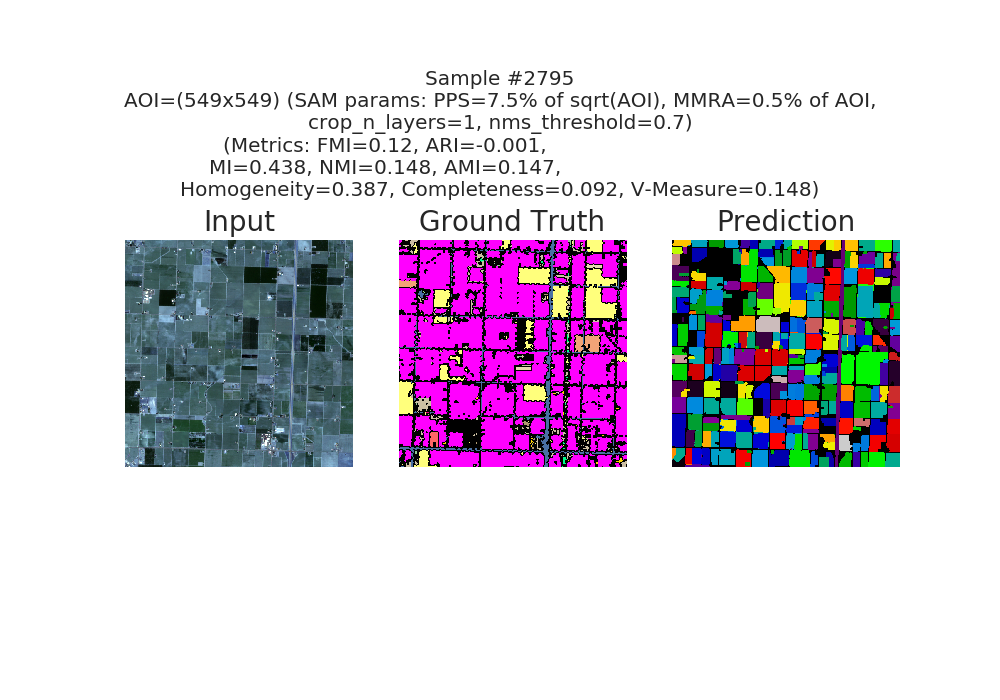

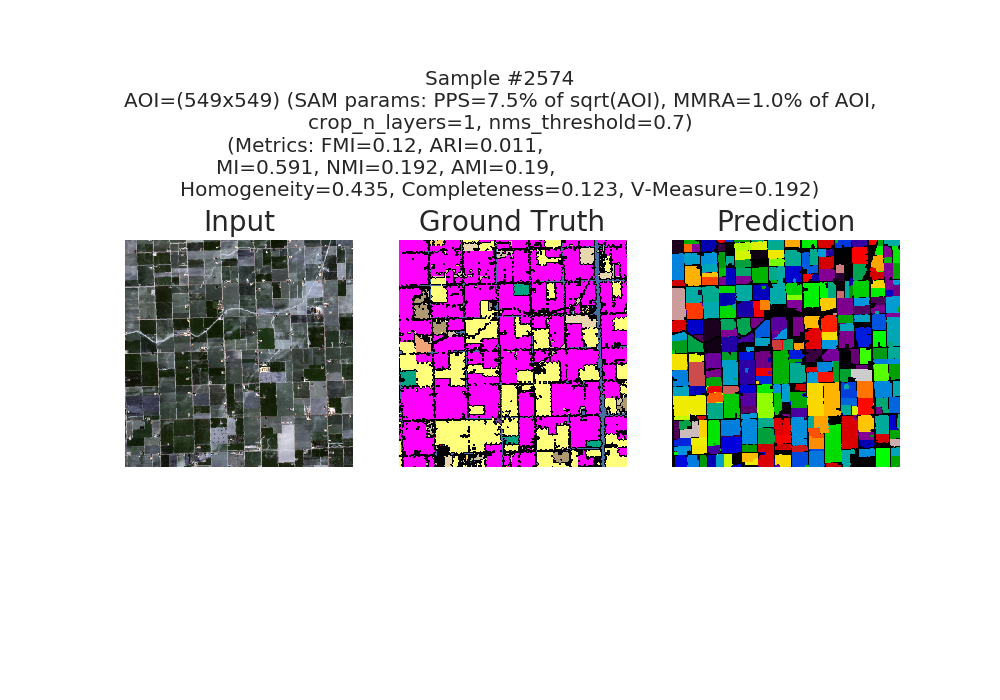

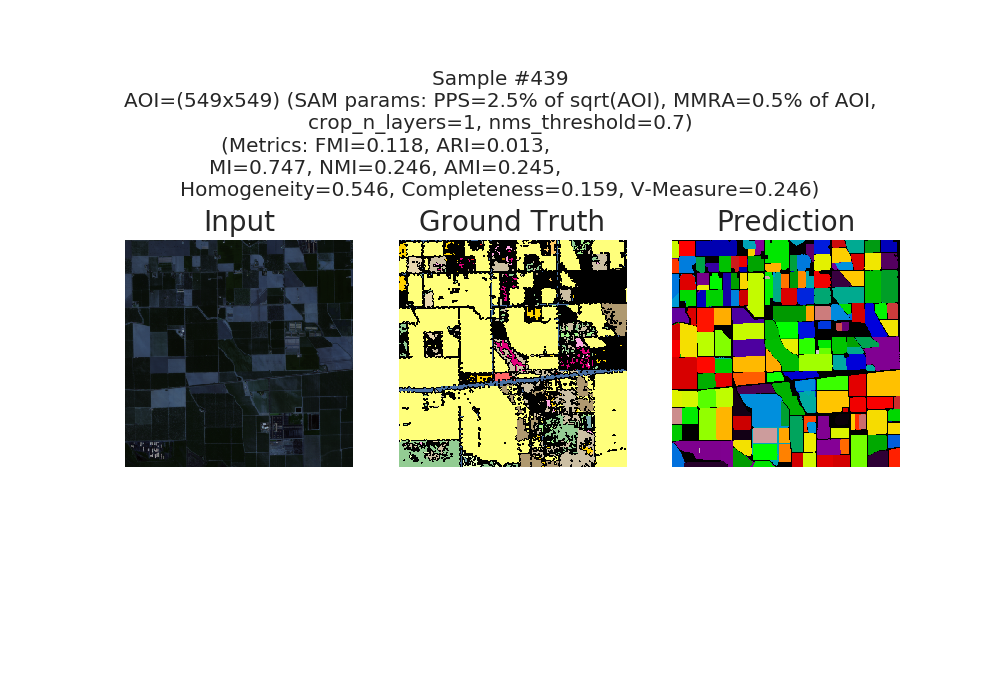

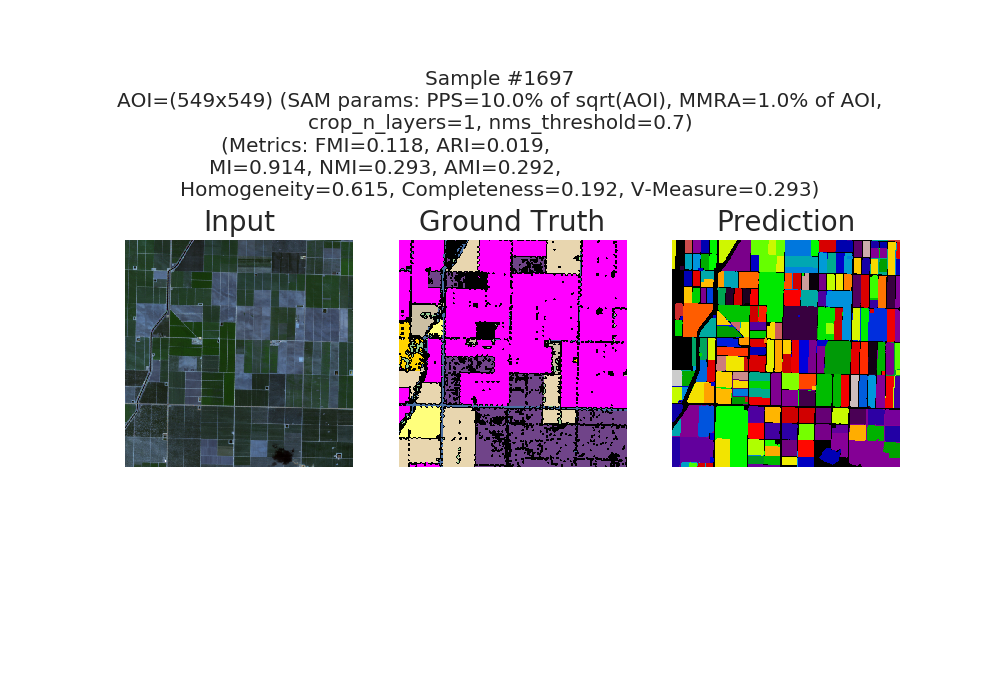

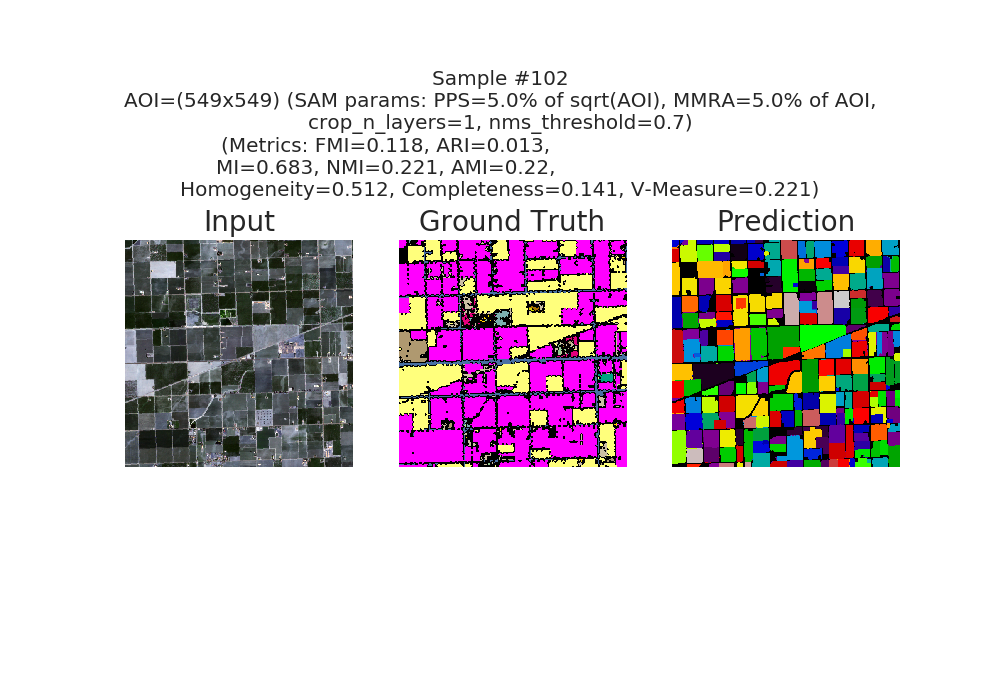

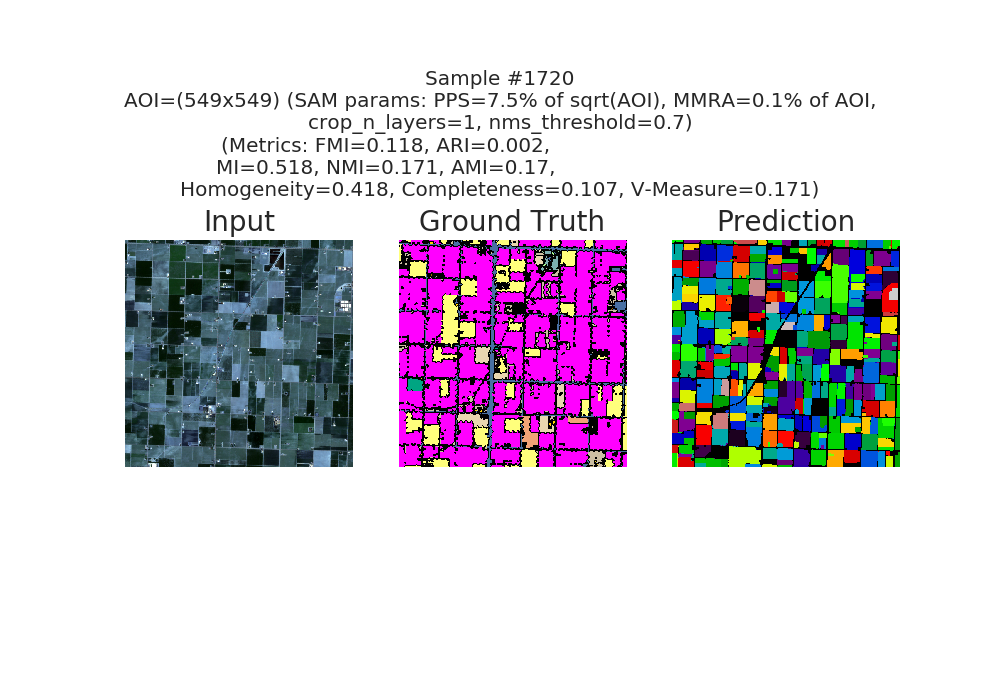

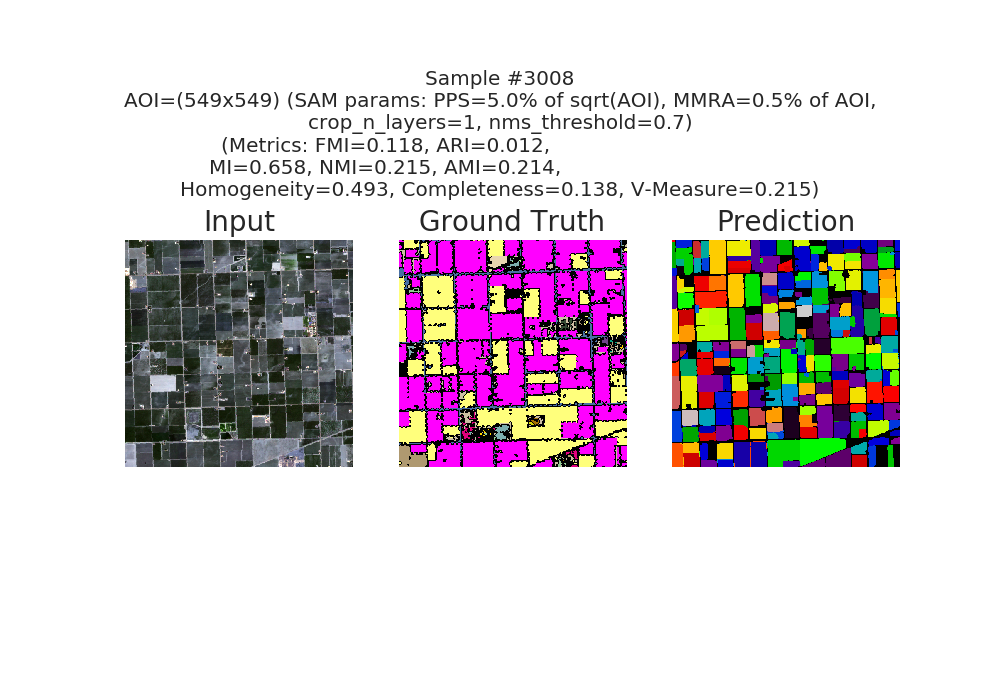

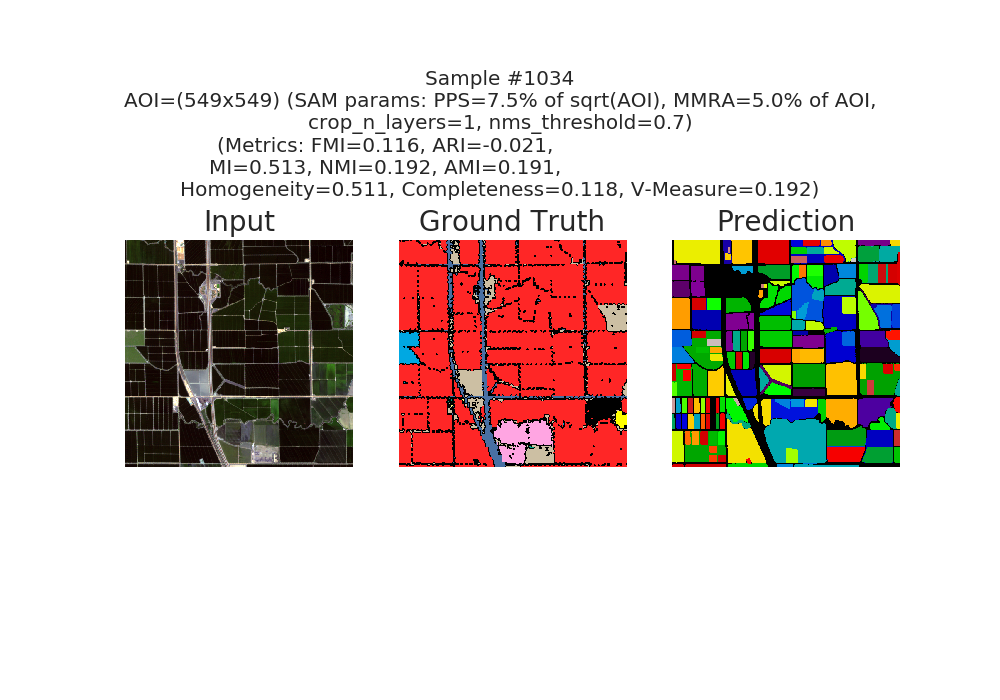

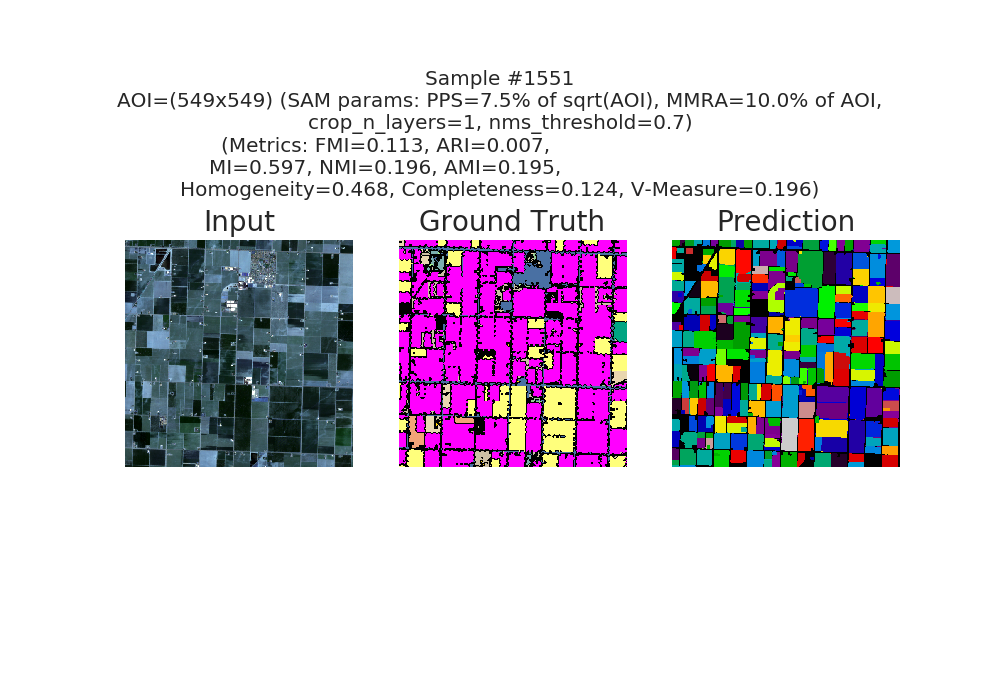

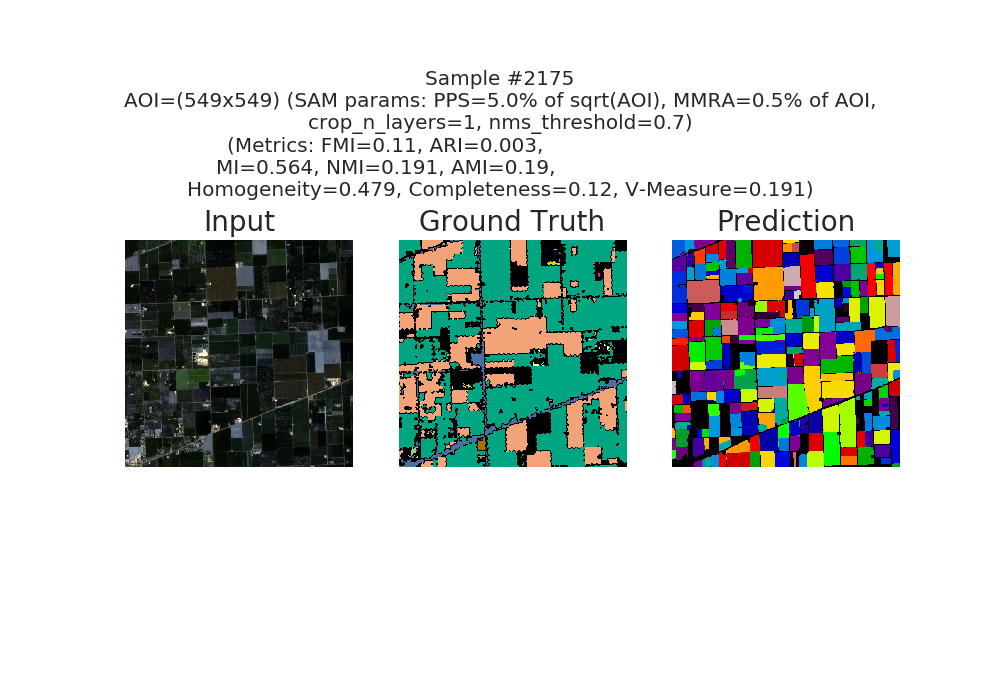

In [19]:
from IPython.display import Image, display

samples_to_display = results[(results.FMI.between(0.0, 0.12, inclusive=True)) 
                                & (results.aoi == 549) 
                                # & (results.pps_perc == 10.0)
                            ]
print(len(samples_to_display), len(samples_to_display['sample_idx'].unique()))
samples_to_display = samples_to_display.drop_duplicates(subset=['sample_idx'])

n=10
if len(samples_to_display) > n:
    samples_to_display = samples_to_display.sample(n)

for index, row in samples_to_display.iterrows():
    aoi_size, mmra_perc, pps_perc, sample_id = int(row['aoi']), row['mmra_perc'], row['pps_perc'], int(row['sample_idx'])
    filepath = RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/aoi_size_{aoi_size}/mmra_perc_{mmra_perc}/pps_perc_{pps_perc}/cropnlayers_1/nms_thresh_0.7/plots/sample_{sample_id}_titled.png"

    display(Image(filename=filepath))

#### Top tails samples

Get samples from the top tails i.e. high scoring samples

40 8


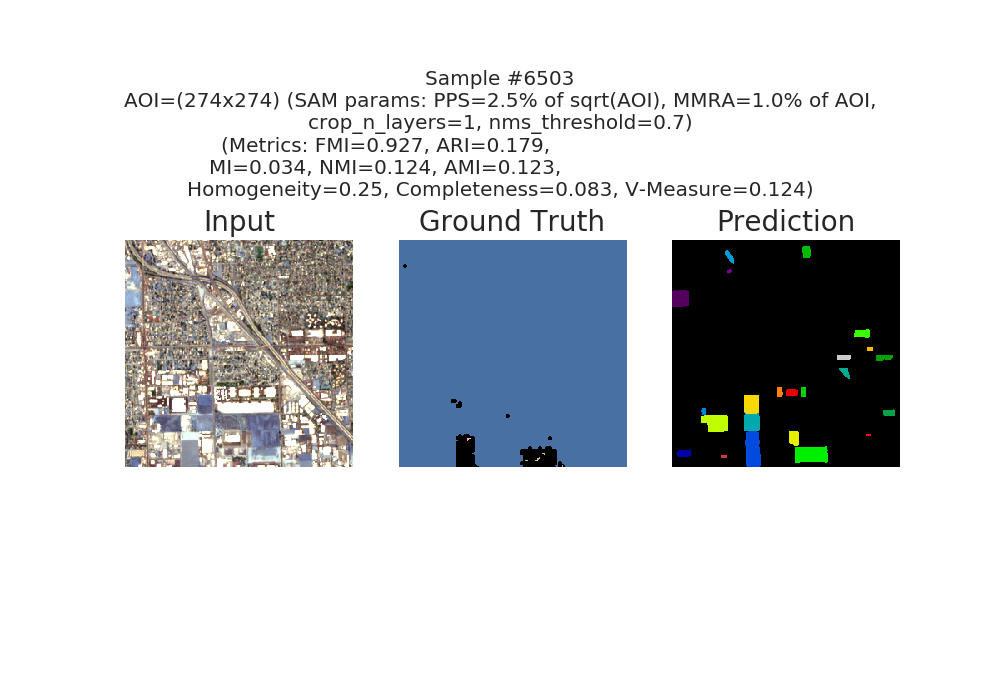

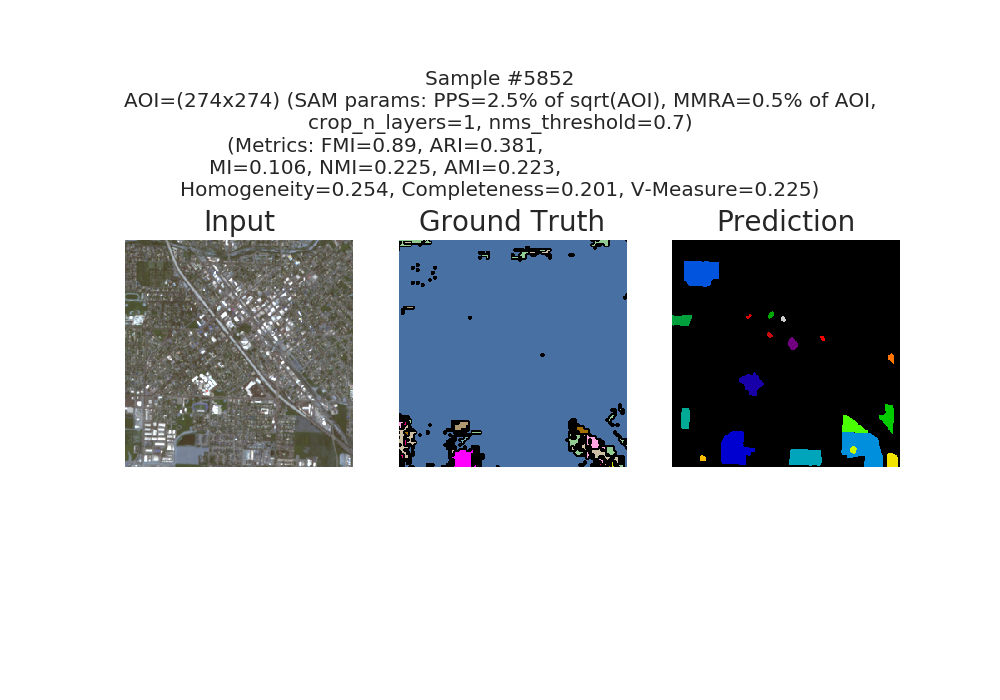

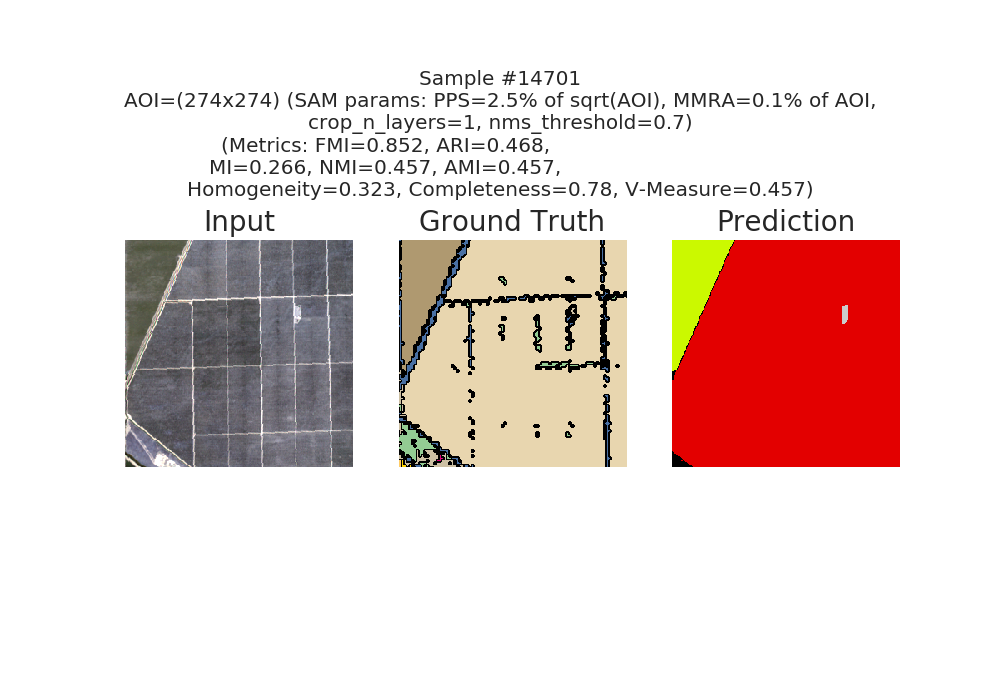

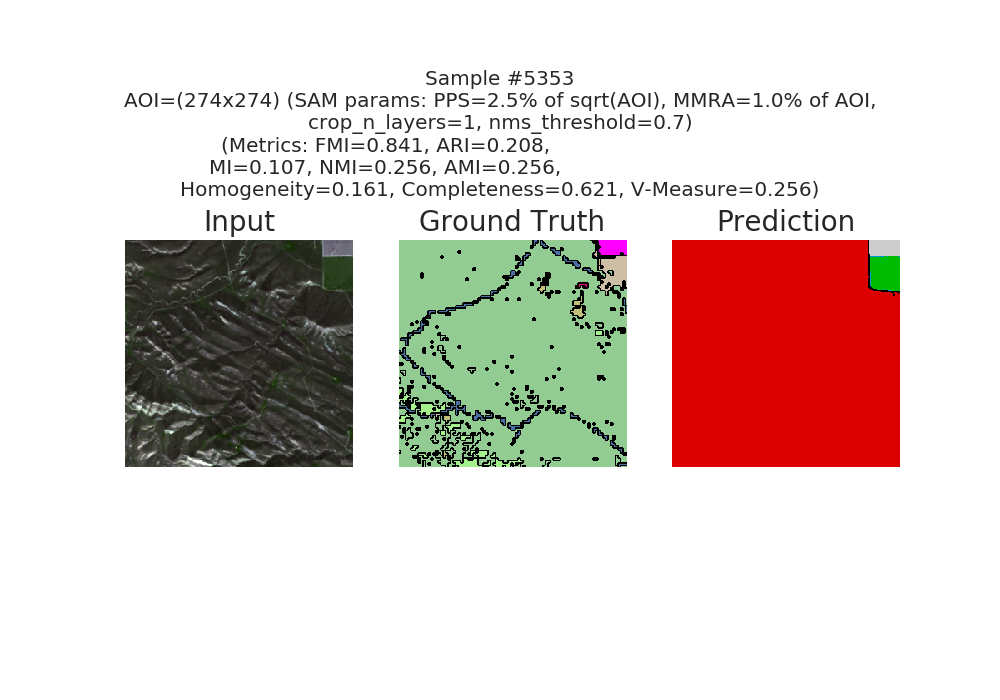

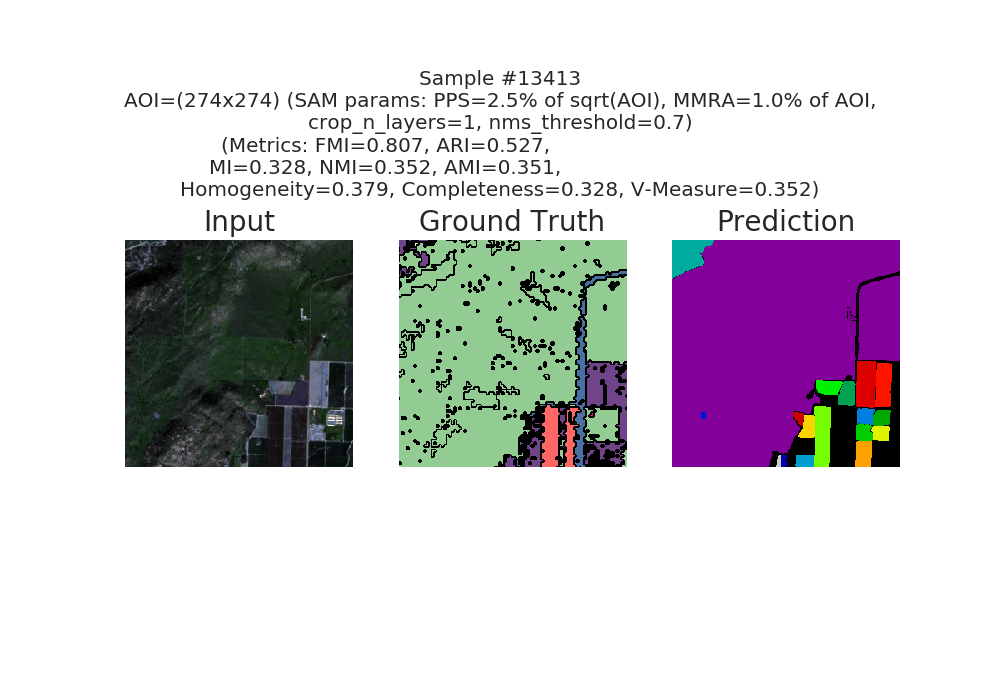

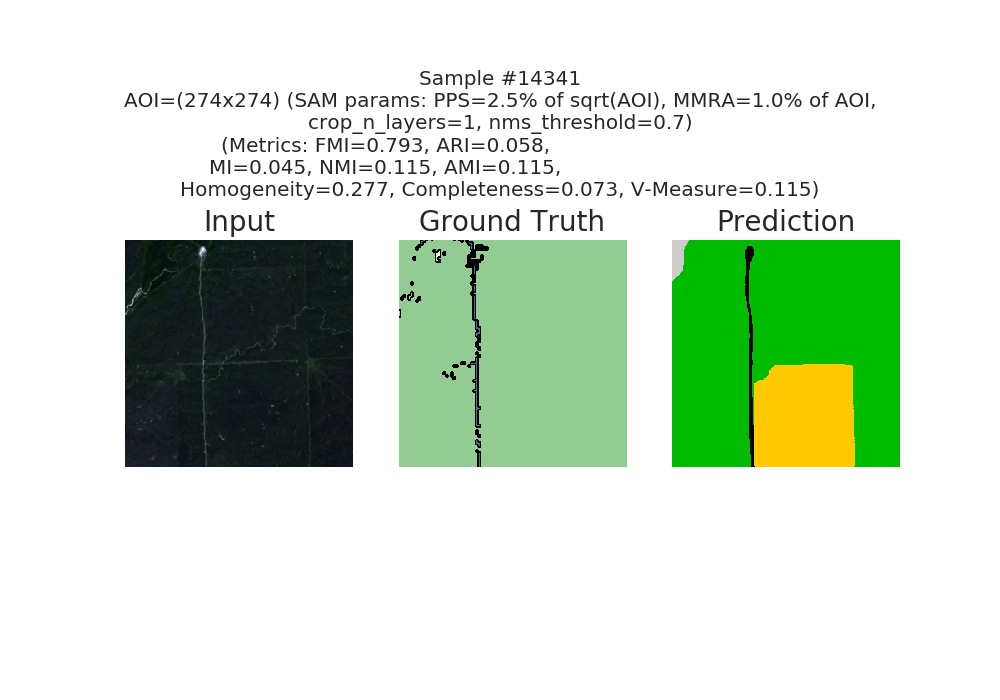

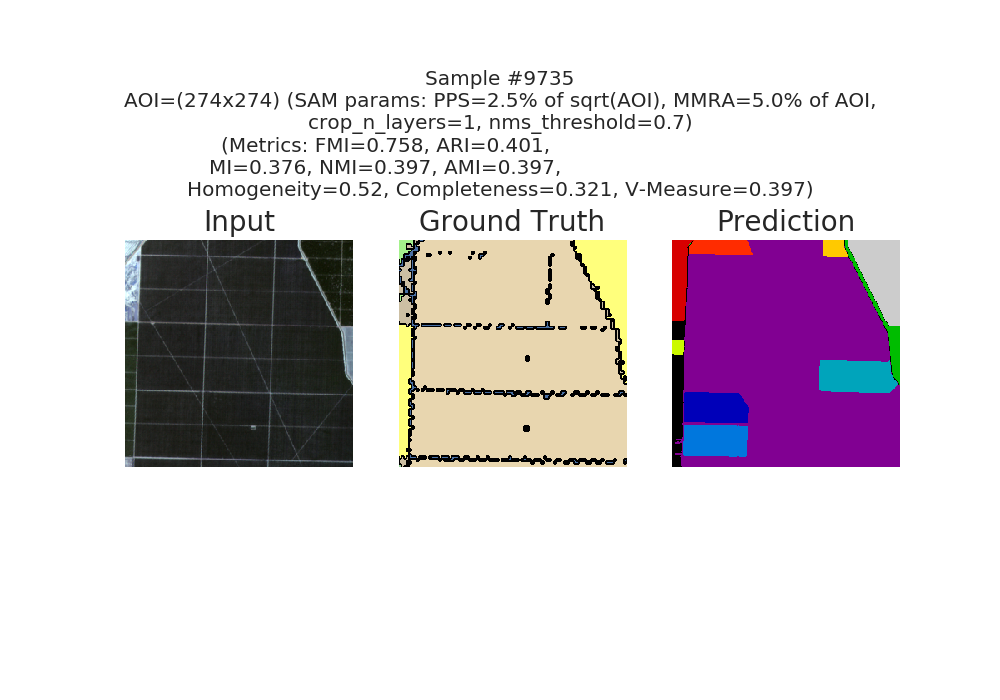

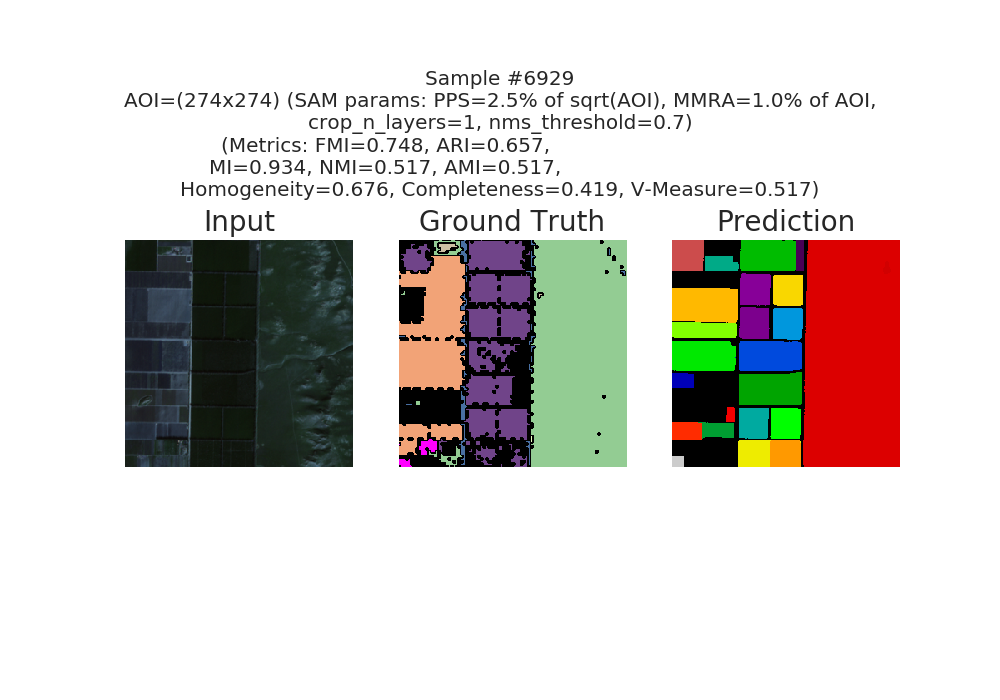

In [19]:
from IPython.display import Image, display

samples_to_display = results[(results.FMI.between(0.70, 0.99, inclusive=True)) 
                                & (results.aoi == 274) 
                                & (results.pps_perc == 2.5)
                            ]
print(len(samples_to_display), len(samples_to_display['sample_idx'].unique()))
samples_to_display = samples_to_display.drop_duplicates(subset=['sample_idx'])

n=10
if len(samples_to_display) > n:
    samples_to_display = samples_to_display.sample(n)

for index, row in samples_to_display.iterrows():
    aoi_size, mmra_perc, pps_perc, sample_id = int(row['aoi']), row['mmra_perc'], row['pps_perc'], int(row['sample_idx'])
    filepath = RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/aoi_size_{aoi_size}/mmra_perc_{mmra_perc}/pps_perc_{pps_perc}/cropnlayers_1/nms_thresh_0.7/plots/sample_{sample_id}_titled.png"

    display(Image(filename=filepath))

#### Mean samples

Get samples with mean FMI and some std away from mean.

68 13


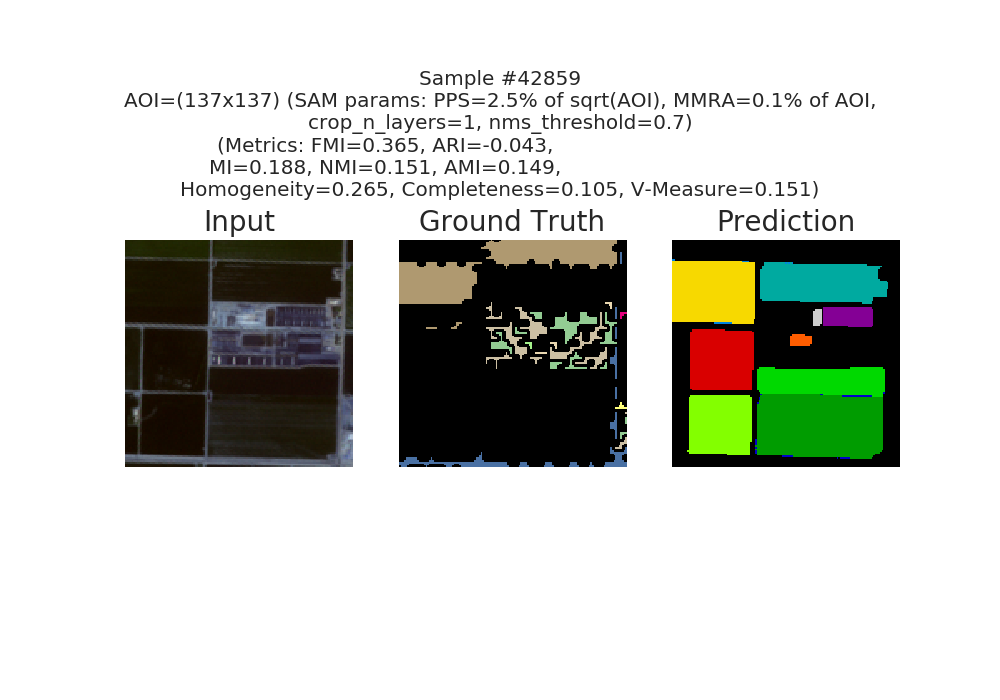

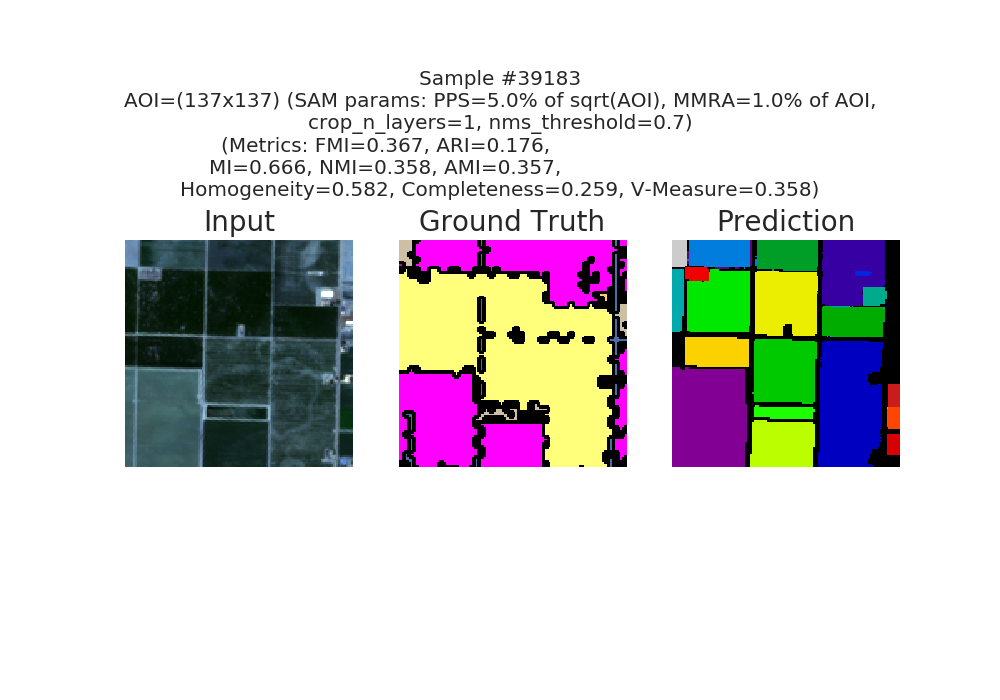

In [9]:
from IPython.display import Image, display
mean_FMI, std_FMI, std_frac = results.FMI.mean(), results.FMI.std(), 0.01
samples_to_display = results[(results.FMI.between(mean_FMI-(std_frac*std_FMI), 
                                                  mean_FMI+(std_frac*std_FMI),
                                                  inclusive=True)) 
                                & (results.aoi == 137) 
                                # & (results.pps_perc == 10.0)
                            ]
print(len(samples_to_display), len(samples_to_display['sample_idx'].unique()))
samples_to_display = samples_to_display.drop_duplicates(subset=['sample_idx'])

n=2
if len(samples_to_display) > n:
    samples_to_display = samples_to_display.sample(n)

for index, row in samples_to_display.iterrows():
    aoi_size, mmra_perc, pps_perc, sample_id = int(row['aoi']), row['mmra_perc'], row['pps_perc'], int(row['sample_idx'])
    filepath = RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/aoi_size_{aoi_size}/mmra_perc_{mmra_perc}/pps_perc_{pps_perc}/cropnlayers_1/nms_thresh_0.7/plots/sample_{sample_id}_titled.png"

    display(Image(filename=filepath))

#### Mean samples at different PPS% and MMRA%

29 10


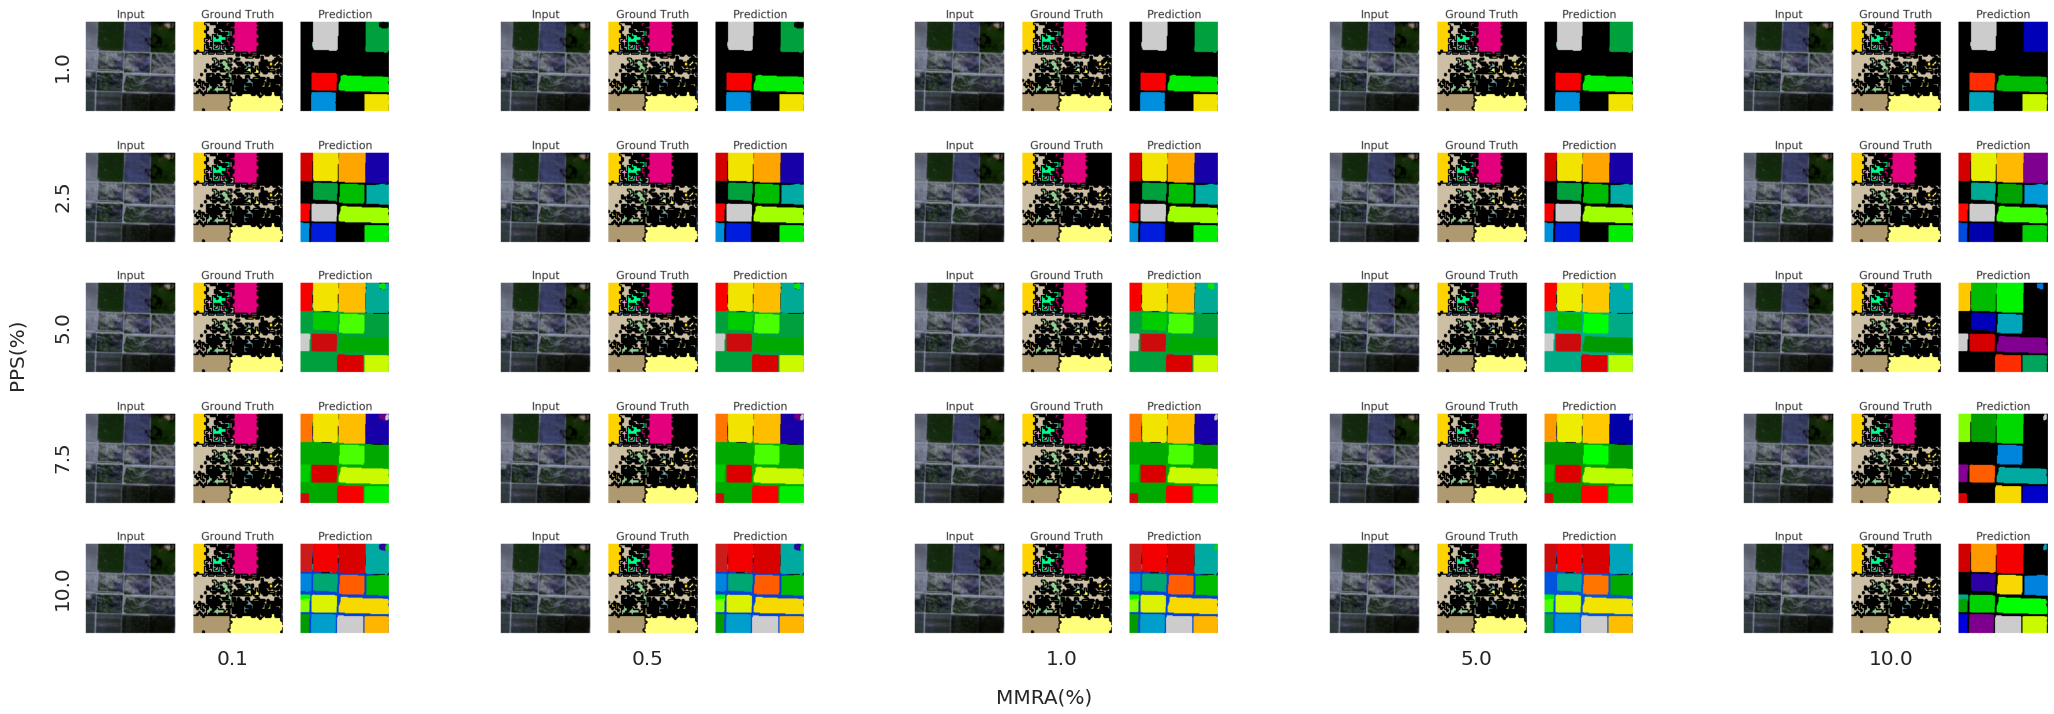

In [24]:
mean_FMI, std_FMI, std_frac = results.FMI.mean(), results.FMI.std(), 0.005
samples_to_display = results[(results.FMI.between(mean_FMI-(std_frac*std_FMI), 
                                                  mean_FMI+(std_frac*std_FMI),
                                                  inclusive=True)) 
                                & (results.aoi == 137) 
                                # & (results.pps_perc == 1.0)
                            ]

print(len(samples_to_display), len(samples_to_display['sample_idx'].unique()))
samples_to_display = samples_to_display.drop_duplicates(subset=['sample_idx'])

mmra_perc_vals = [0.1, 0.5, 1.0, 5.0, 10.0]
pps_perc_vals = [1.0, 2.5, 5.0, 7.5, 10.0]

row = samples_to_display.iloc[1]
sample_id, aoi_size = int(row['sample_idx']), int(row['aoi'])
fig, axes = plt.subplots(len(pps_perc_vals), len(mmra_perc_vals), figsize=(30,10))
for i, mmra_perc in enumerate(mmra_perc_vals):
    for j, pps_perc in enumerate(pps_perc_vals):
        filepath = RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/aoi_size_{aoi_size}/mmra_perc_{mmra_perc}/pps_perc_{pps_perc}/cropnlayers_1/nms_thresh_0.7/plots/sample_{sample_id}.png"
        img = plt.imread(filepath)
        v,h = 200, 100
        img = img[v:img.shape[0]-v, h:img.shape[1]-h, :]
        axes[pps_perc_vals.index(pps_perc), mmra_perc_vals.index(mmra_perc)].imshow(img)
        # axes[pps_perc_vals.index(pps_perc), mmra_perc_vals.index(mmra_perc)].axis('off')
        axes[pps_perc_vals.index(pps_perc), mmra_perc_vals.index(mmra_perc)].set_xticks([])
        axes[pps_perc_vals.index(pps_perc), mmra_perc_vals.index(mmra_perc)].set_yticks([])
        if i == 0:
            axes[pps_perc_vals.index(pps_perc), mmra_perc_vals.index(mmra_perc)].set_ylabel(f"{pps_perc}", fontsize=20)
        if j == len(mmra_perc_vals)-1:
            axes[pps_perc_vals.index(pps_perc), mmra_perc_vals.index(mmra_perc)].set_xlabel(f"{mmra_perc}", fontsize=20)

fig.supxlabel("MMRA(%)", fontsize=20)
fig.supylabel("PPS(%)", fontsize=20)
plt.tight_layout()

Looks like MMRA doesn't have much if any effect on predicted masks. So only vizualizing mean samples at varying PPS(%).

29 10
['FMI', 'NMI', 'ARI', 'V-Measure']
[0.571 0.141 0.034 0.141]
[0.343 0.219 0.058 0.219]
[0.332 0.24  0.072 0.24 ]
[0.327 0.254 0.077 0.254]
[0.306 0.239 0.07  0.239]


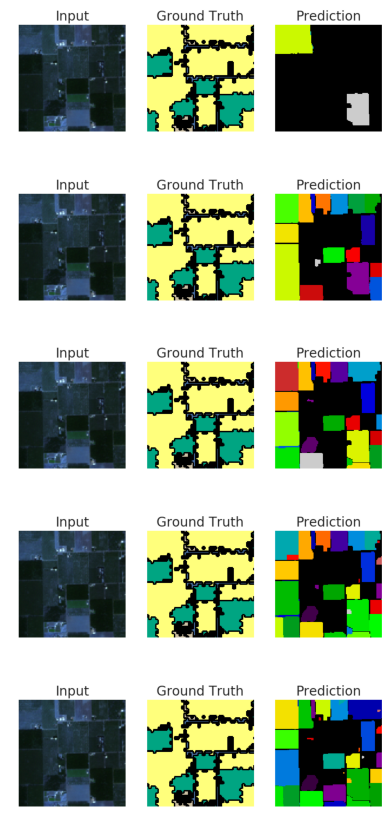

In [25]:
mean_FMI, std_FMI, std_frac = results.FMI.mean(), results.FMI.std(), 0.005
samples_to_display = results[(results.FMI.between(mean_FMI-(std_frac*std_FMI), 
                                                  mean_FMI+(std_frac*std_FMI),
                                                  inclusive=True)) 
                                & (results.aoi == 137) 
                                # & (results.pps_perc == 1.0)
                            ]

print(len(samples_to_display), len(samples_to_display['sample_idx'].unique()))
unique_samples_to_display = samples_to_display.drop_duplicates(subset=['sample_idx'])

mmra_perc_vals = [0.1, 0.5, 1.0, 5.0, 10.0]
pps_perc_vals = [1.0, 2.5, 5.0, 7.5, 10.0]

row = unique_samples_to_display.iloc[3]
sample_id, aoi_size = int(row['sample_idx']), int(row['aoi'])
mmra_perc = mmra_perc_vals[-1]
chosen_metrics = ['FMI', 'NMI', 'ARI', 'V-Measure']
print(chosen_metrics)
fig, axes = plt.subplots(len(pps_perc_vals), 1, figsize=(20,15))
for pps_perc in pps_perc_vals:
    filepath = RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/aoi_size_{aoi_size}/mmra_perc_{mmra_perc}/pps_perc_{pps_perc}/cropnlayers_1/nms_thresh_0.7/plots/sample_{sample_id}.png"
    img = plt.imread(filepath)
    v,h = 200, 100
    img = img[v:img.shape[0]-v, h:img.shape[1]-h, :]
    df = results[(results['sample_idx'] == sample_id) & 
                (results['pps_perc'] == pps_perc) &
                (results['mmra_perc'] == mmra_perc)
            ]
    # fmi = np.round(df['FMI'].values[0],2)
    # print(fmi)
    metrics_df = df[chosen_metrics]
    print(metrics_df.values[0])
                            
    axes[pps_perc_vals.index(pps_perc)].imshow(img)
    # axes[pps_perc_vals.index(pps_perc)].axis('off')
    axes[pps_perc_vals.index(pps_perc)].set_xticks([])
    axes[pps_perc_vals.index(pps_perc)].set_yticks([])
    # axes[pps_perc_vals.index(pps_perc)].set_ylabel(f"{pps_perc}   ", fontsize=15, rotation=0)
    # axes[pps_perc_vals.index(pps_perc)].set_title(f"FMI = {fmi}", fontsize=15)

    # ax = axes[pps_perc_vals.index(pps_perc)].twinx()
    # ax.set_yticks([])
    # ax.set_ylabel(f"     {fmi}", fontsize=15, rotation=0)

# plt.savefig(RESULTS_DIR+f"/grid_search/num_samples_{num_samples}/agg_plots/sample_{sample_id}_at_varying_perc_pps.png", dpi=300)
    